In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import re

# Gráficos
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación del modelo
# ==============================================================================
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# Realiza la tokenización
# ==============================================================================
def split_text(text):
  return re.findall(r'\S+', text)

# Remueve 'palabras vacías'
# ==============================================================================
def remove_stop_words(text, stop_words):
  result = []
  subwords = split_text(text)
  for item in subwords:
      if not item in stop_words:
          result.append(item)
  return result

# Remueve acentos por medio de regex.
# ==============================================================================
def remove_accents(text):
  new_text = re.sub(r'[àáâãäå]', 'a', text)
  new_text = re.sub(r'[èéêë]', 'e', new_text)
  new_text = re.sub(r'[ìíîï]', 'i', new_text)
  new_text = re.sub(r'[òóôõö]', 'o', new_text)
  new_text = re.sub(r'[ùúûü]', 'u', new_text)
  return new_text

# Remueve emojis y otros caracteres especiales.
# ==============================================================================
def remove_emojis(text):
  emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # Emoticones
    u"\U0001F300-\U0001F5FF"  # Símbolos y pictogramas
    u"\U0001F680-\U0001F6FF"  # Símbolos de mapas y transporte
    u"\U0001F1E0-\U0001F1FF"  # Banderas de iOS
    u"\U00002500-\U00002BEF"  # Kanji
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # Dingbats
    u"\u3030"
    "]+",
    re.UNICODE
  )
  return re.sub(emoj, '', text)

In [3]:
# Lectura de datos
# ==============================================================================
meade_tweets = pd.read_csv("meade.csv")
amlo_tweets = pd.read_csv("amlo.csv")
anaya_tweets = pd.read_csv("anaya.csv")

print(f'Número de tweets @Meade: { meade_tweets.shape[0] }')
print(f'Número de tweets @AMLO: { amlo_tweets.shape[0] }')
print(f'Número de tweets @Anaya: { anaya_tweets.shape[0] }')

# Se unen los tres dataframes en uno solo
# ==============================================================================
tweets = pd.concat([meade_tweets, amlo_tweets, anaya_tweets], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
# ==============================================================================
tweets = tweets[['regarding_candidate', 'tweet']]
tweets.columns = ['regarding_candidate', 'tweet']

Número de tweets @Meade: 69
Número de tweets @AMLO: 248
Número de tweets @Anaya: 200


In [4]:
tweets


,regarding_candidate,tweet
0,JoseAMeadeK,"Dos proyectos abismalmente diferentes, uno bus..."
1,JoseAMeadeK,"Una elección de dos proyectos, uno que busca r..."
2,JoseAMeadeK,En respuesta a econokafka Ya un tribunal resol...
3,JoseAMeadeK,En respuesta a econokafka Porque la PGR está a...
4,JoseAMeadeK,En respuesta a carlosortegap Meade le deseo su...
...,...,...
512,RicardoAnayaC,En respuesta a MidgardoR FelipeCalderon y Rica...
513,RicardoAnayaC,En respuesta a yuspio FelipeCalderon y Ricardo...
514,RicardoAnayaC,En respuesta a FelipeCalderon y RicardoAnayaCY...
515,RicardoAnayaC,En respuesta a FelipeCalderon y RicardoAnayaC ...


In [5]:
# Función utilizada para visualizar el entrenamiento de los modelos (extraída del curso Procesamiento de Imágenes y Lab.).
# ==============================================================================
def plot_boundaries(model,X_train,y_train):
  # Based on https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

  cmap_light = ListedColormap(["#009F4C", "#017AC1", "#BF3119"])

  h = 1  # step size in the mesh
  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
  y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=cmap_light)

  # Plot also the training points
  sns.set_style("whitegrid");
  sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue = y_train,
  )
  plt.show()

  return None

In [6]:
# Evaluación del modelo a través del cálculo del FScore.
# ==============================================================================
def eval_model(y_test,y_pred):
  return f1_score(y_test, y_pred, average='micro')

In [7]:
# Importa archivo de palabras vacías y las almacena en una lista.
# ==============================================================================
f = open("./stop-words.txt", encoding="utf8")
lines = f.read().splitlines()
stop_words = []
for x in lines:
  x = remove_accents(x)
  stop_words.append(x)
f.close()

In [8]:
'''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
'''
def cleaner_and_tokenizer(text):
    # Se convierte todo el texto a minúsculas.
    # ==============================================================================
    new_text = text.lower()
    # Eliminación de páginas web (palabras que empiezan por "http").
    # ==============================================================================
    new_text = re.sub('http\S+', ' ', new_text)
    # Eliminación de signos de puntuación.
    # ==============================================================================
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    new_text = re.sub(regex , ' ', new_text)
    # Eliminación de números.
    # ==============================================================================
    new_text = re.sub("\d+", ' ', new_text)
    # Eliminación de espacios en blanco múltiples.
    # ==============================================================================
    new_text = re.sub("\\s+", ' ', new_text)
    # Eliminación de emojis.
    # ==============================================================================
    new_text = remove_emojis(new_text)
    # Eliminación de acentos.
    # ==============================================================================
    new_text = remove_accents(new_text)
    # Eliminación de stop_words y tokenización por palabras individuales.
    # ==============================================================================
    new_text = remove_stop_words(new_text, stop_words= stop_words)
    # Eliminación de tokens con una longitud < 2
    # ==============================================================================
    new_text = [token for token in new_text if len(token) > 1]

    return new_text

test = "Esto https://t.co/rnHPgyhx4Z @cienciadedatos #textmining 💻aleatorio 😊😀 😃王明是中国人。王明是学生。 史密斯是美国人。 史密斯是王明的朋友"
print(test)
print(cleaner_and_tokenizer(text=test))

Esto https://t.co/rnHPgyhx4Z @cienciadedatos #textmining 💻aleatorio 😊😀 😃王明是中国人。王明是学生。 史密斯是美国人。 史密斯是王明的朋友
['esto', 'cienciadedatos', 'textmining', 'aleatorio']


In [9]:
# Aplicamos la función cleaner_and_tokenizer para limpiar y tokenizar todos los tweets.
# ==============================================================================
tweets['tokenizer_tweet'] = tweets['tweet'].apply(lambda x: cleaner_and_tokenizer(x))
tweets[['tweet', 'tokenizer_tweet']].head()

,tweet,tokenizer_tweet
0,"Dos proyectos abismalmente diferentes, uno bus...","[dos, proyectos, abismalmente, diferentes, uno..."
1,"Una elección de dos proyectos, uno que busca r...","[una, eleccion, de, dos, proyectos, uno, que, ..."
2,En respuesta a econokafka Ya un tribunal resol...,"[en, respuesta, econokafka, ya, un, tribunal, ..."
3,En respuesta a econokafka Porque la PGR está a...,"[en, respuesta, econokafka, porque, la, pgr, e..."
4,En respuesta a carlosortegap Meade le deseo su...,"[en, respuesta, carlosortegap, meade, le, dese..."


In [10]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='tokenizer_tweet')
tweets_tidy = tweets_tidy.drop(columns='tweet')
tweets_tidy = tweets_tidy.rename(columns={'tokenizer_tweet':'token'})

In [11]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='regarding_candidate')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


regarding_candidate
JoseAMeadeK      1852
RicardoAnayaC    4720
lopezobrador_    5973
Name: token, dtype: int64

In [12]:
# Longitud media de los tweets.
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["regarding_candidate"])["token"].count())
temp_df.reset_index().groupby("regarding_candidate")["token"].agg(['mean'])

,mean
regarding_candidate,
JoseAMeadeK,1852.0
RicardoAnayaC,4720.0
lopezobrador_,5973.0


In [13]:
# Top 5 palabras más utilizadas por cada candidato
# ==============================================================================
tweets_tidy.groupby(['regarding_candidate','token'])['token'] \
  .count() \
  .reset_index(name='count') \
  .groupby('regarding_candidate') \
  .apply(lambda x: x.sort_values('count', ascending=False).head(5))

regarding_candidate          token  count
regarding_candidate                                               
JoseAMeadeK         199          JoseAMeadeK             en     87
                    143          JoseAMeadeK             de     77
                    574          JoseAMeadeK      respuesta     64
                    548          JoseAMeadeK            que     57
                    191          JoseAMeadeK             el     54
RicardoAnayaC       1202       RicardoAnayaC             en    214
                    1903       RicardoAnayaC            que    186
                    1951       RicardoAnayaC      respuesta    171
                    1065       RicardoAnayaC             de    165
                    1957       RicardoAnayaC  ricardoanayac    129
lopezobrador_       2828       lopezobrador_             en    266
                    3686       lopezobrador_            que    223
                    2668       lopezobrador_             de    213
                    3756       lopezobrador_      respuesta    181
                    2810       lopezobrador_             el    171

In [14]:
# Donde x se refiere al tweet y y al autor.
# ==============================================================================
data_x = tweets.loc[tweets.regarding_candidate.isin(['JoseAMeadeK', 'RicardoAnayaC', 'lopezobrador_']), 'tweet']
data_y = tweets.loc[tweets.regarding_candidate.isin(['JoseAMeadeK', 'RicardoAnayaC', 'lopezobrador_']), 'regarding_candidate']

data_x = np.array(data_x)
data_y = np.array(data_y)

# Reparto train (70%) y test (30%) 
# ==============================================================================
x_train, x_test, y_train, y_test = train_test_split(
    data_x,
    data_y,
    test_size = 0.3,
    random_state = 75
)

# Representar a los candidatos numéricamente para que los modelos los acepten.
# ==============================================================================
y_train[y_train == "lopezobrador_"] = 2
y_train[y_train == "RicardoAnayaC"] = 1
y_train[y_train == "JoseAMeadeK"] = 0
y_train = y_train.astype('int')

y_test[y_test == "lopezobrador_"] = 2
y_test[y_test == "RicardoAnayaC"] = 1
y_test[y_test == "JoseAMeadeK"] = 0
y_test = y_test.astype('int')

In [15]:
# Vectorización de los datos.
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
  tokenizer  = cleaner_and_tokenizer,
  min_df     = 5, # Ignora elemenos que no aparezcan en al menos 5 documentos.
)

# Entrenando vectorizador.
# ==============================================================================
tfidf_vectorizador.fit(x_train)

# Transformando datos.
# ==============================================================================
tfidf_train = tfidf_vectorizador.fit_transform(x_train)
tfidf_test = tfidf_vectorizador.transform(x_test)

print("Número de tokens creados:" + str(len(tfidf_vectorizador.get_feature_names_out ())))
print(tfidf_vectorizador.get_feature_names_out()[:10])

Número de tokens creados:199
['ademas' 'ahora' 'al' 'amlo' 'anaya' 'apoyo' 'asi' 'aun' 'aunque'
 'aurelionuno']


c:\Users\Alfredo\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
# Función que realiza la predición de acuerdo a un texto ingresado por consola, donde el modelo a analizar puede ser enviado como parámetro.
# ==============================================================================
def prediction_by_text(final_model):
  user_input = input("Introduzca un tweet: ")
  # Convertimos la entrada del usuario a un arreglo numpy.
  # ==============================================================================
  user_input = np.array(user_input).reshape(-1)
  # Limpiamos, tokenizamos y vectorizamos la entrada del usuario.
  # ==============================================================================
  tfidf_usertest = tfidf_vectorizador.transform(user_input)
  print(user_input)
  # Realiza la predicción con base en el modelo de clasificación enviado como parámetro.
  # ==============================================================================
  user_predict = final_model.predict(tfidf_usertest)[0]
  
  # Decisión final de a quién le pertenece el voto.
  # ==============================================================================
  if user_predict == 0:
    print("El voto está dirigido para Meade")
  elif user_predict == 1:
    print("El voto está dirigido para Anaya")
  else: 
    print("El voto está dirigido para AMLO")

In [17]:
# Entrenamiento y evaluación del modelo K Vecinos más cercanos.
# ==============================================================================
knn_model = KNeighborsClassifier(n_neighbors = 7)
knn_model.fit(tfidf_train, y_train)
y_knn_predict = knn_model.predict(tfidf_test)

print(f"train shape: { tfidf_train.shape }")
print(f"test shape: { tfidf_test.shape }")
print(f'KNN FScore: { eval_model(y_test, y_knn_predict) }')

train shape: (361, 199)
test shape: (156, 199)
KNN FScore: 0.6025641025641025


c:\Users\Alfredo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [18]:
# Predicción de un Tweet introducido por el usuario con K Vecinos más cercanos.
# ==============================================================================
prediction_by_text(knn_model)

['hola']
El voto está dirigido para AMLO


c:\Users\Alfredo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


c:\Users\Alfredo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Alfredo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Alfredo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN Visualization FScore: 0.3974358974358974


c:\Users\Alfredo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


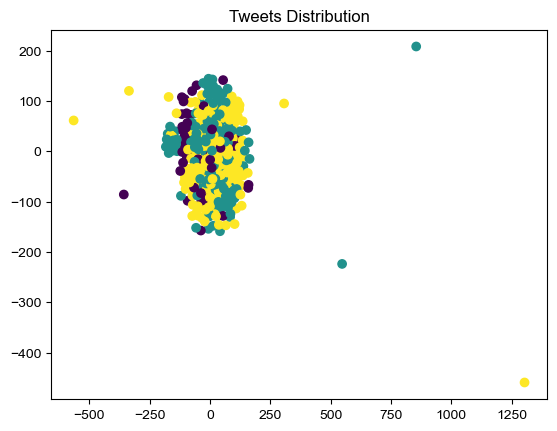

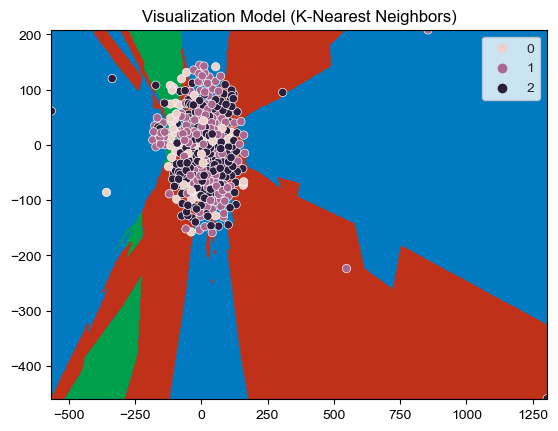

In [19]:
# Se reduce la dimensionalidad de los datos (matrices) con el método TSNE, esto para poder visualizar los modelos.
# ==============================================================================
clf = TSNE(n_components=2)
X_reduced_train = clf.fit_transform(tfidf_train)
X_reduced_test = clf.fit_transform(tfidf_test)

# Se muestra una gráfica con la distribución espacial de los Tweets.
# ==============================================================================
plt.title("Tweets Distribution")
plt.scatter(x=X_reduced_train[:,0], y=X_reduced_train[:,1], c=y_train)
plt.figure()

# Entrenamiento, evaluación y visualización del modelo K Vecinos más cercanos.
# ==============================================================================
visualization_knn_model = KNeighborsClassifier(n_neighbors = 7)
visualization_knn_model.fit(X_reduced_train, y_train)
print(f'KNN Visualization FScore: { eval_model(y_test, visualization_knn_model.predict(X_reduced_test) ) }')

plt.title('Visualization Model (K-Nearest Neighbors)')
plot_boundaries(visualization_knn_model, X_reduced_train, y_train)


Decision Tree FScore: 0.9038461538461539


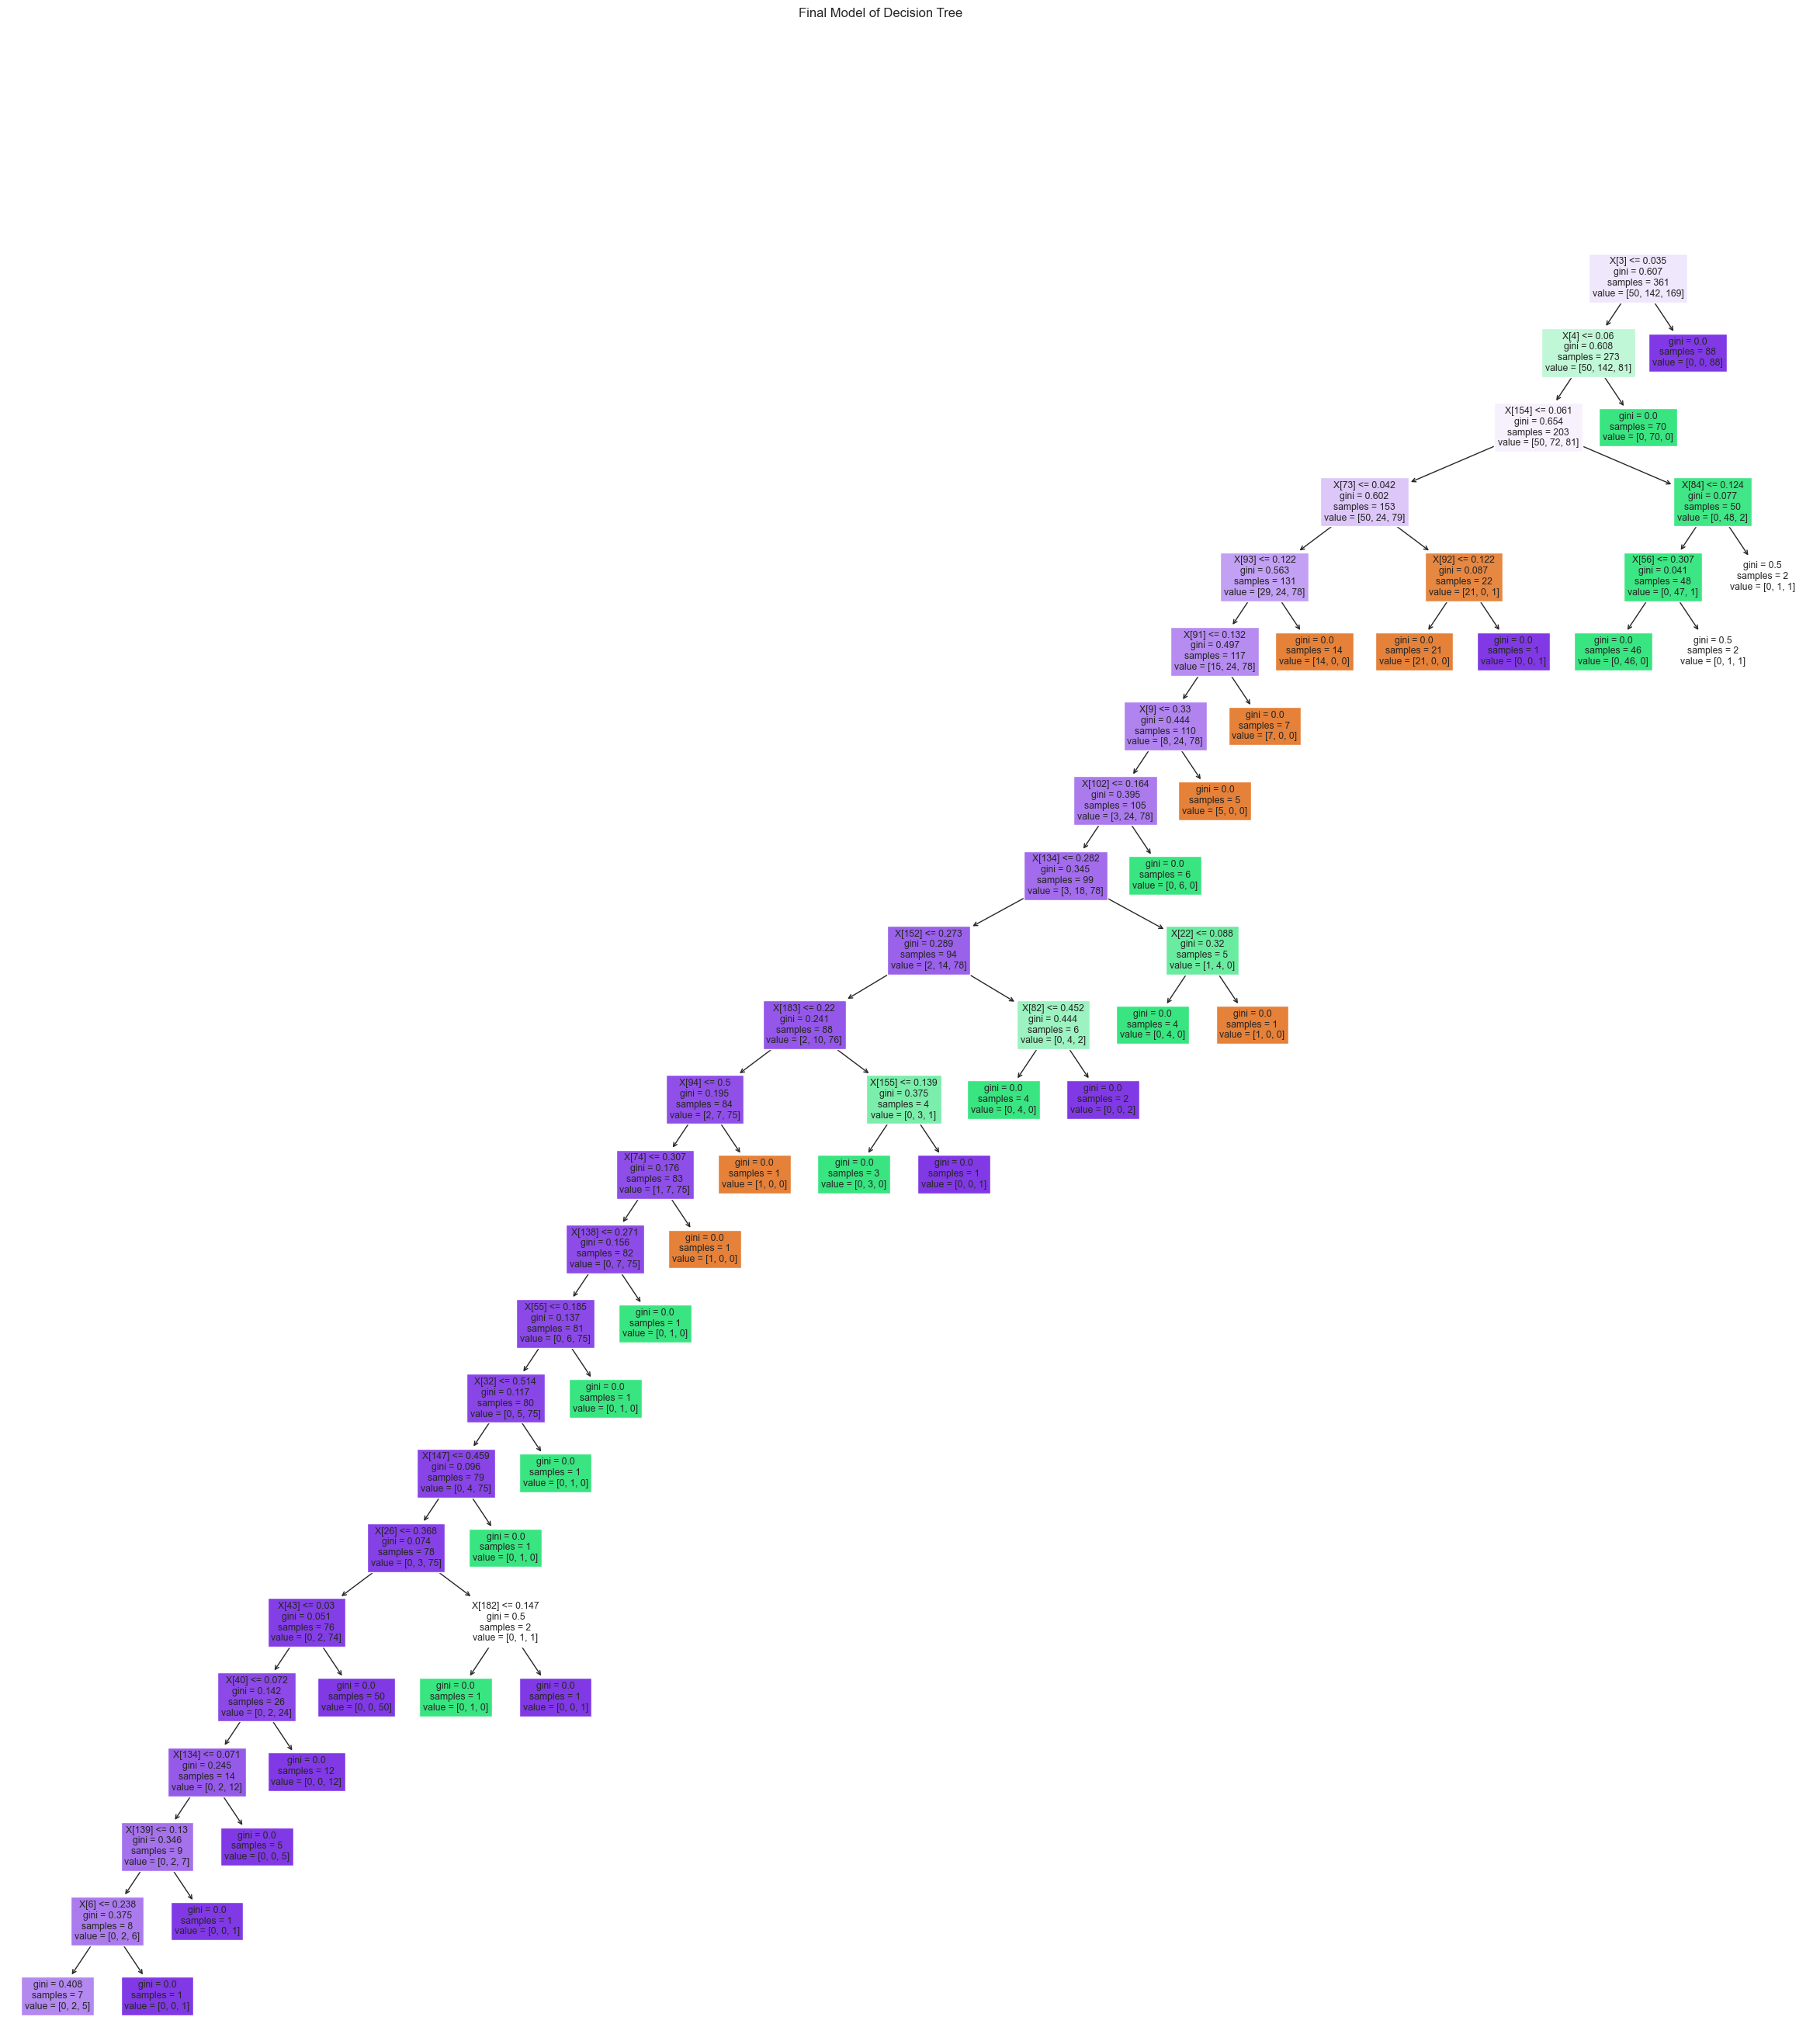

In [20]:
# Entrenamiento, evaluación del modelo Árboles de Decisión.
# ==============================================================================
dt_model = DecisionTreeClassifier()

dt_model.fit(tfidf_train, y_train)
y_predict = dt_model.predict(tfidf_test)

print(f'Decision Tree FScore: { eval_model(y_test, y_predict) }')

_, ax = plt.subplots(figsize=(30,30)) # Aumentando el tamaño de la gráfica del árbol de decisión.
plot_tree(dt_model, filled=True, ax=ax)
plt.suptitle('Final Model of Decision Tree')
plt.show()

In [21]:
# Predicción de un Tweet introducido por el usuario con árboles de decisión.
# ==============================================================================
prediction_by_text(dt_model)

['meade']
El voto está dirigido para Meade


Decision Tree Visualization FScore: 0.28205128205128205


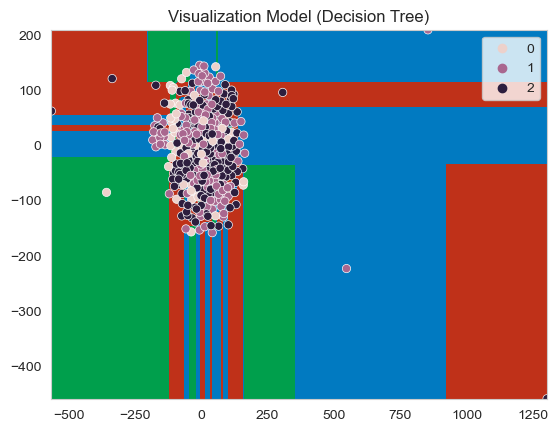

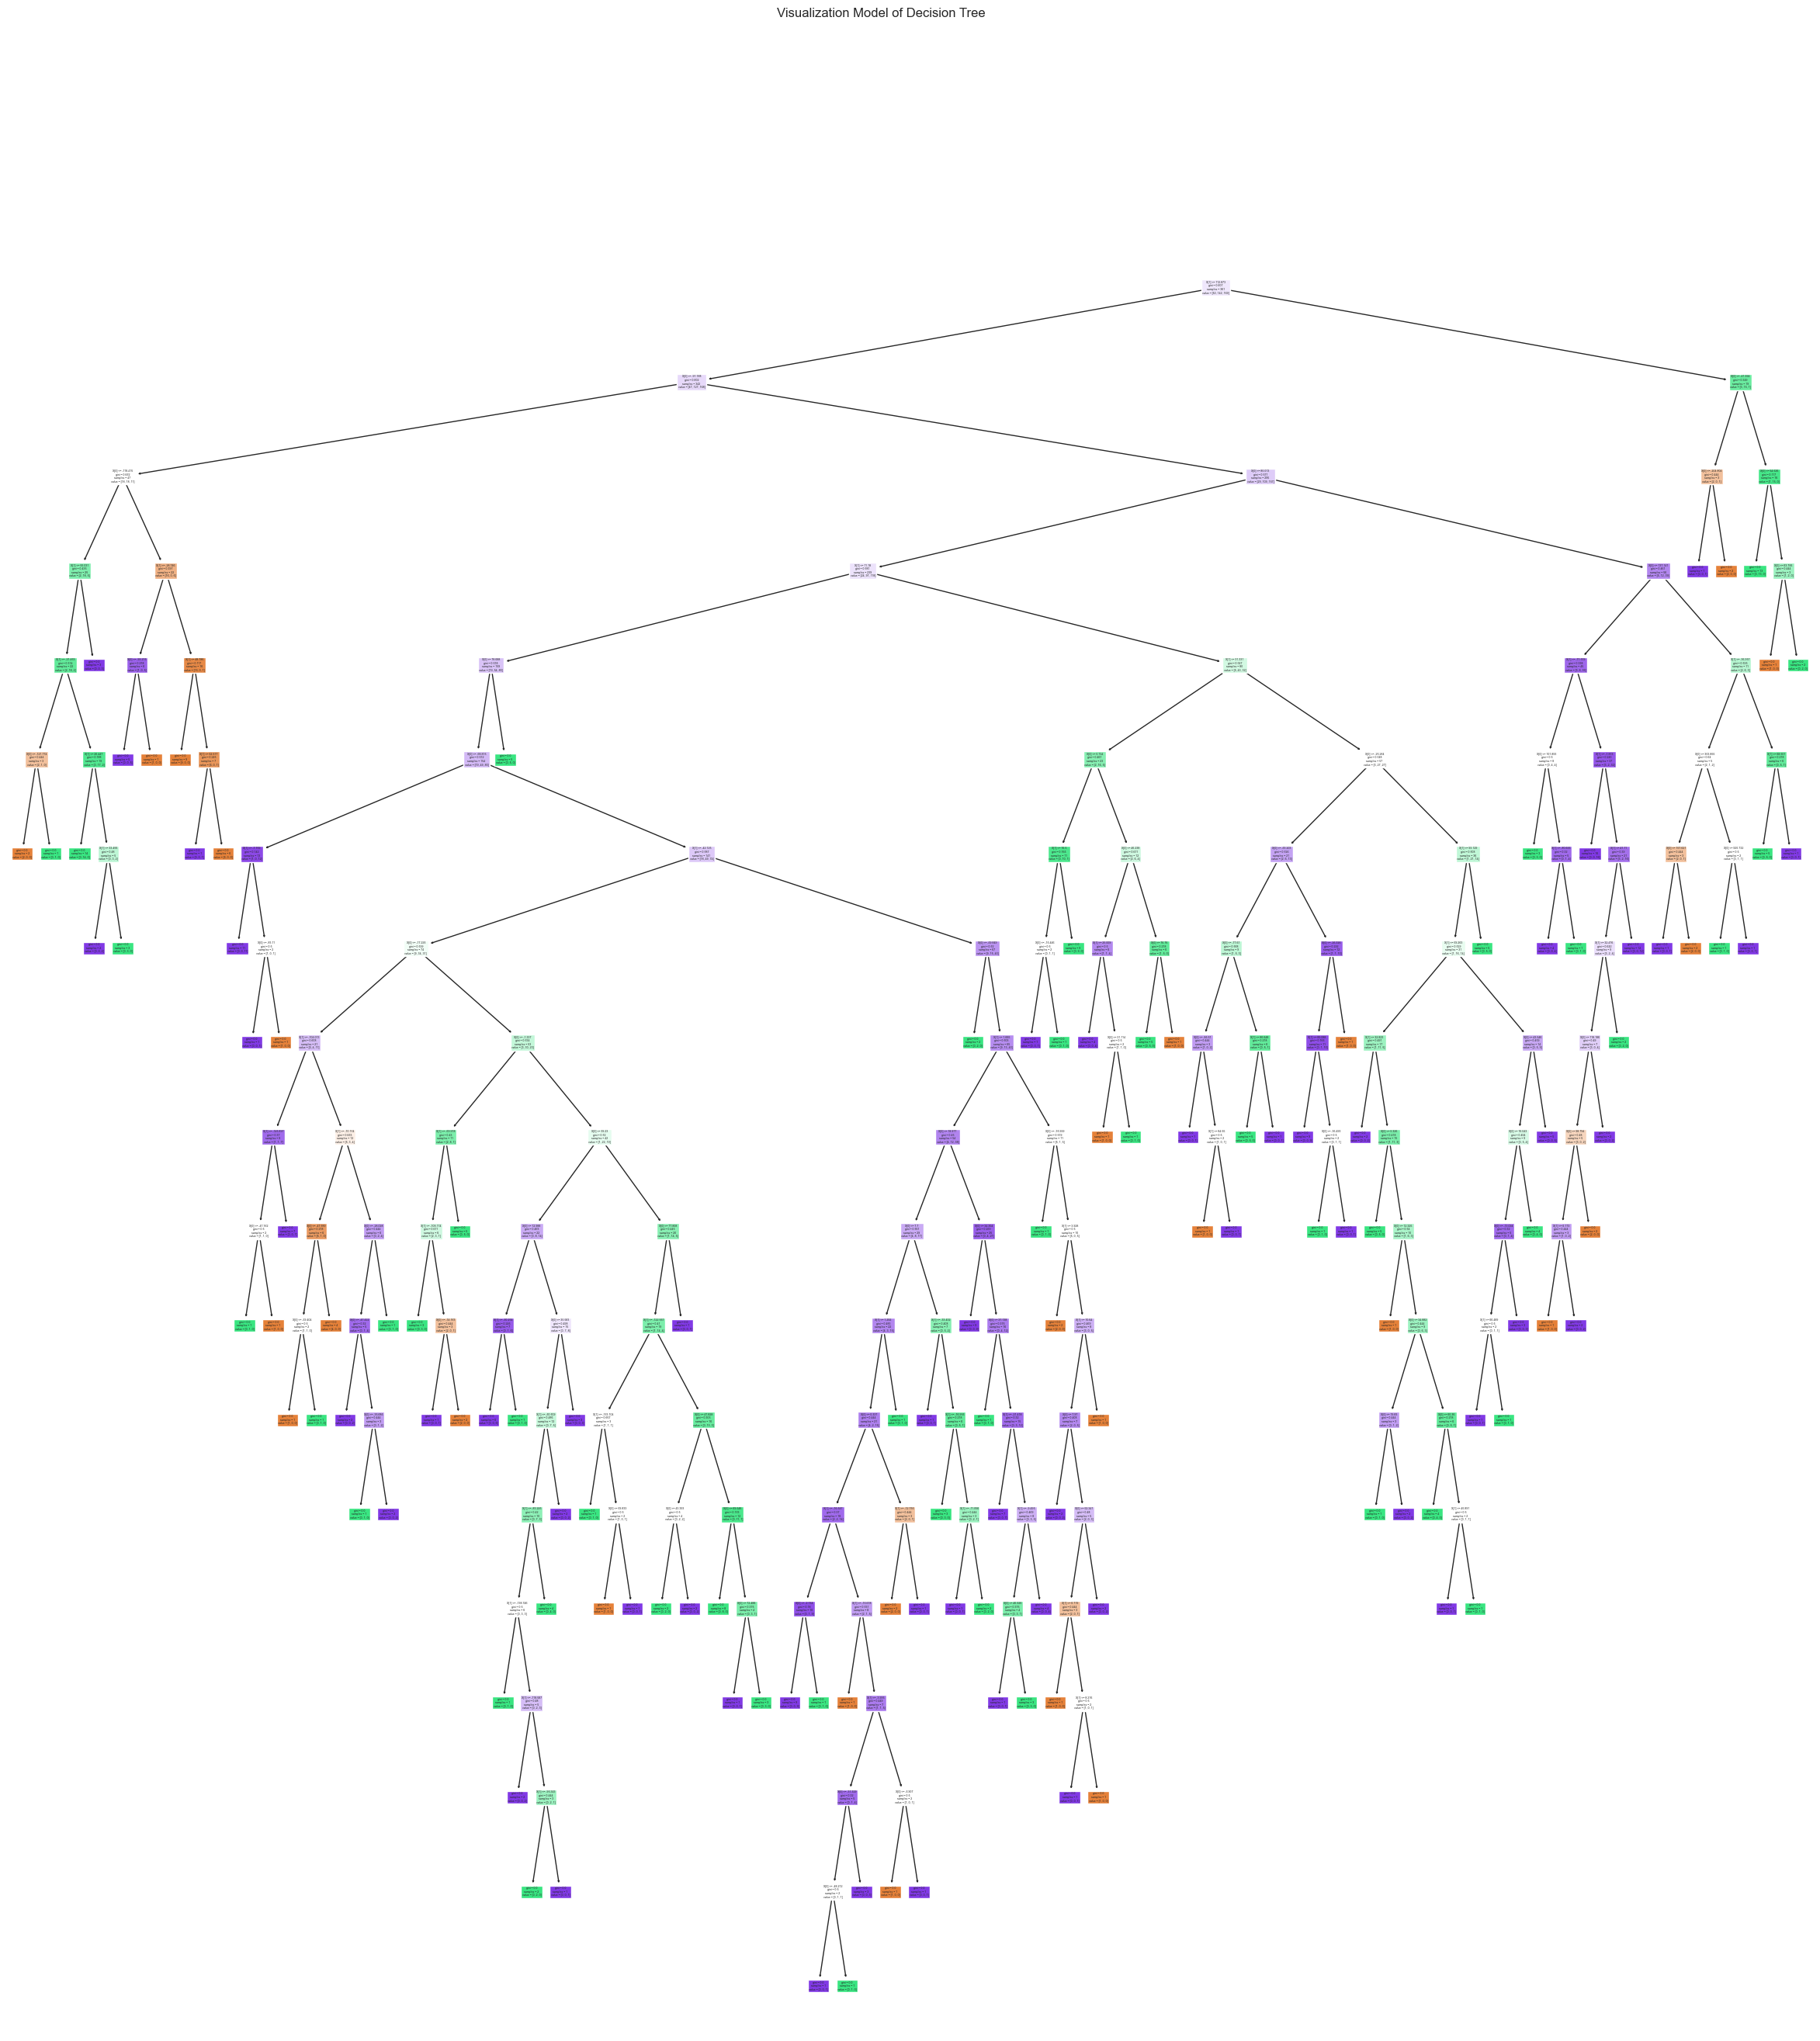

In [22]:
# Entrenamiento, evaluación y visualización del modelo árboles de decisión.
# ==============================================================================
dt_visualization_model = DecisionTreeClassifier()

dt_visualization_model.fit(X_reduced_train, y_train)
y_predict = dt_visualization_model.predict(X_reduced_test)

print(f'Decision Tree Visualization FScore: { eval_model(y_test, y_predict) }')
plt.title('Visualization Model (Decision Tree)')
plot_boundaries(dt_visualization_model, X_reduced_train, y_train)

_, ax = plt.subplots(figsize=(30,30)) # Aumentando el tamaño de la gráfica del árbol de decisión.
plot_tree(dt_visualization_model,filled=True, ax=ax)
plt.suptitle('Visualization Model of Decision Tree')
plt.show()

In [23]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Se genera un grid con los resultados de los modelos de SVM para determinar cuál es el hiperpárametro que se ajusta más al contexto.
# ==============================================================================
grid = GridSearchCV(
    estimator  = SVC(),
    param_grid = param_grid,
    scoring    = 'accuracy',
    n_jobs     = -1,
    return_train_score = True
)

# Se entrena el grid de modelos de SVM.
# ==============================================================================
grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,0.877930,0.034766,0.987531,0.005190
7,16.681005,0.877930,0.036919,0.990302,0.005093
8,129.154967,0.877930,0.036919,0.990302,0.005093
9,1000.0,0.877930,0.036919,0.990302,0.005093
5,0.278256,0.625913,0.031707,0.739607,0.016068
0,0.00001,0.468151,0.005511,0.468144,0.001374
1,0.000077,0.468151,0.005511,0.468144,0.001374
2,0.000599,0.468151,0.005511,0.468144,0.001374
3,0.004642,0.468151,0.005511,0.468144,0.001374
4,0.035938,0.468151,0.005511,0.468144,0.001374


In [24]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

svm_final_model = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 2.154434690031882} : 0.8779299847792998 accuracy


SVM Visualization FScore: 0.28205128205128205


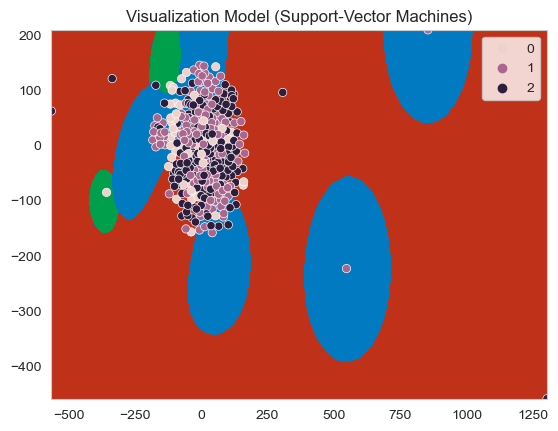

In [25]:
# Entrenamiento, evaluación y visualización del modelo SVM.
# ==============================================================================
svm_visualization_model = SVC()
svm_visualization_model.fit(X_reduced_train,y_train)

y_predict = dt_visualization_model.predict(X_reduced_test)
print(f'SVM Visualization FScore: { eval_model(y_test, y_predict) }')

plt.title('Visualization Model (Support-Vector Machines)')
plot_boundaries(svm_visualization_model, X_reduced_train, y_train)

In [26]:
# Predicción de un Tweet introducido por el usuario con máquina de vectores de soporte.
# ==============================================================================
prediction_by_text(svm_final_model)

['7']
El voto está dirigido para AMLO


In [27]:
# Error en predicciones (test)
# ==============================================================================
test_predictions = svm_final_model.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != test_predictions).sum()}"
)
print(f"% de error: {100*(y_test != test_predictions).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")

# Obteniendo matriz de confusión
# ==============================================================================
cm = confusion_matrix(y_true = y_test, y_pred= test_predictions)

# Métodos de evaluación del modelo SVM.
# ==============================================================================
precision = np.diag(cm) / np.sum(cm, axis = 0)
recall = np.diag(cm) / np.sum(cm, axis = 1)
f_score = 2 * ((precision * recall)/(precision + recall))

# Visualización de la matriz de confusión.
# ==============================================================================
print(confusion_matrix(y_true = y_test, y_pred= test_predictions))
print(pd.DataFrame(
      confusion_matrix(y_true = y_test, y_pred= test_predictions),
      columns= ["Meade", "Anaya", "AMLO"],
      index = ["Meade", "Anaya", "AMLO"]
))

print("")
print("-------------------")
print("Evaluación")
print("-------------------")
print('Precisión:', np.mean(precision))
print('Recall:', np.mean(recall))
print('Fscore:', np.mean(f_score))

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 156 clasificaciones: 23
% de error: 14.743589743589745

-------------------
Matriz de confusión
-------------------
[[12  0  7]
 [ 0 52  6]
 [ 2  8 69]]
       Meade  Anaya  AMLO
Meade     12      0     7
Anaya      0     52     6
AMLO       2      8    69

-------------------
Evaluación
-------------------
Precisión: 0.8550909794812234
Recall: 0.8005161310084464
Fscore: 0.8219238388729915


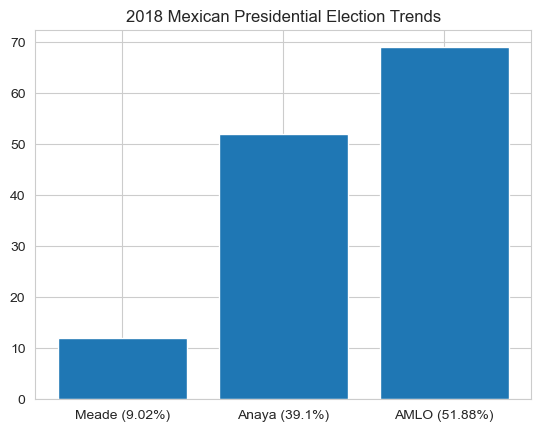

In [28]:
# Calculando porcentajes de las tendencias.
# ==============================================================================
values = np.diag(cm)
total = sum(values); # Se obtiene el total de las prediciones efectivas.
percents = []

# Se aplica la fórmula y se limita a dos decimales cada porcentaje.
# ==============================================================================
for value in values:
  percents.append( round((value / total) * 100, 2) )

# Se muestra la gráfica de tendencias.
# ==============================================================================
names = [f'Meade ({ percents[0] }%)', f'Anaya ({ percents[1] }%)', f'AMLO ({ percents[2] }%)']
plt.title('2018 Mexican Presidential Election Trends')
plt.bar(names, values)
plt.show()